In [95]:
!pip install forex-python

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import requests
import json
import time
import joblib
import datetime

from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.preprocessing import StandardScaler

from forex_python.converter import CurrencyRates

###RandomizedSearchCV

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score

In [97]:
def change_currency(val, curr_from, curr_to):
  if curr_from != curr_to:
    curr_from = curr_from.upper()
    curr_to = curr_to.upper()
    c = CurrencyRates()
    return round(val/c.get_rate(curr_to, curr_from, datetime.datetime.now()))

In [98]:
def remove_mark(value):
    marks = ['>', '<', '-', '+', '_', ' ', '  ', ',']
    for mark in marks:
        if pd.notna(value) and mark in value:
            return value.replace(mark, '')
    return value

In [99]:
def remove_blanc(value):
    if value == '':
        value = 0
        return value

In [100]:
def evaluate_regression_model(model, X_test, y_test):
    """
    Evaluates the performance of a regression model and provides a summary.

    Parameters:
        model: A trained regression model from scikit-learn.
        X_test: Test features.
        y_test: Test labels.
    """
    # Predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)  # RMSE
    r2 = r2_score(y_test, y_pred)

    # Display results
    print("Regression Model Evaluation:")
    print("===========================")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R-squared (R2): {r2:.2f}")

In [101]:
def api_to_df(url):
    response = requests.get(url)
    content = response.json()
    return pd.DataFrame.from_records(content)


In [102]:
def to_csv_date(df, filename):
    current_date = pd.Timestamp("today").strftime("%m%d%Y")
    df.to_csv(filename + '_' + current_date + '_.csv', index = False)


In [103]:
def remove_null_col(df):
    return df.dropna(axis=1, how='all', inplace = False)

In [104]:
def flatten_list_col(df):
    new_df = pd.DataFrame()
    nested_columns_list = []
    for i, col in enumerate(df.columns):
        if any(isinstance(item, list) for item in df[col]):
            nested_columns_list.append(col)
            new_df= pd.concat([new_df, df[col].apply(pd.Series)], axis = 1)
    new_columns = list(range(len(new_df.columns)))
    new_df.columns = new_columns
    return new_df

In [105]:
def flatten_dict_col(df):
    new_df = pd.DataFrame()
    nested_columns_list = []
    for i, col in enumerate(df.columns):
        if any(isinstance(item, dict) for item in df[col]):
            nested_columns_list.append(col)
            new_df= pd.concat([new_df, df[col].apply(pd.Series)], axis = 1)
#     new_columns = list(range(len(new_df.columns)))
#     new_df.columns = new_columns
    new_df = remove_null_col(new_df)
    return new_df

In [106]:
def unpack_nested_col(nested_col, key_name):
    unpacked_col = {}
    nested_col_unpacked = nested_col.apply(pd.Series)
    for i, col in enumerate(nested_col_unpacked.columns):
        unpacked_col[f'{key_name}_{i}'] = nested_col_unpacked[col].apply(pd.Series)
        if 0 in unpacked_col[f'{key_name}_{i}'].columns:
            if unpacked_col[f'{key_name}_{i}'][0].isna().all():
                unpacked_col[f'{key_name}_{i}'].drop(columns = 0, inplace = True)
    return unpacked_col

In [107]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    return df

In [108]:
def replace_cols(recipient_df, col_replaced, donor_df, col_replacing):
    recipient_df.drop(columns = col_replaced, inplace = True)
    recipient_df = pd.concat([recipient_df, donor_df[col_replacing]])
    return recipient_df

## Reading initial data from API. In this step, we accept all offers from the API, but only receive general information. In order to complete the data, we also read each offer separately using its individual API.


## Unpacking the data


In [109]:
df_init = api_to_df('https://justjoin.it/api/offers')

df_init.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12980 entries, 0 to 12979
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   title                    12980 non-null  object
 1   street                   12978 non-null  object
 2   city                     12980 non-null  object
 3   country_code             12974 non-null  object
 4   address_text             12980 non-null  object
 5   marker_icon              12980 non-null  object
 6   workplace_type           12980 non-null  object
 7   company_name             12980 non-null  object
 8   company_url              12980 non-null  object
 9   company_size             12980 non-null  object
 10  experience_level         12980 non-null  object
 11  latitude                 12980 non-null  object
 12  longitude                12980 non-null  object
 13  published_at             12980 non-null  object
 14  remote_interview         12980 non-nul

## Select the subset of the data - only "data" marker icon

In [110]:
# Limit observations to those that have flag 'data'
df_data = df_init[df_init['marker_icon'] == 'data']
df_data.reset_index(drop=True, inplace = True)

## Reading detailed data for every separete offer from API

In [111]:
json_data = []

In [112]:
offers = list(df_data.id)

In [113]:
len(offers)

1100

In [114]:
for offer in offers:
  url = f'https://justjoin.it/api/offers/{offer}'
  response = requests.get(url)
  json_obj = response.json()
#   initial_df = pd.json_normalize(json_obj)
  json_data.append(json_obj)
#   time.sleep(0.5)

In [115]:
df_data_offers = pd.DataFrame(json_data)
to_csv_date(df_data_offers, 'df_data_offers')

In [116]:
df_data_offers.info(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   apply_body               0 non-null      object
 1   title                    1100 non-null   object
 2   street                   1100 non-null   object
 3   city                     1100 non-null   object
 4   country_code             1099 non-null   object
 5   address_text             1100 non-null   object
 6   marker_icon              1100 non-null   object
 7   workplace_type           1100 non-null   object
 8   company_name             1100 non-null   object
 9   company_url              1100 non-null   object
 10  company_size             1100 non-null   object
 11  experience_level         1100 non-null   object
 12  latitude                 1100 non-null   object
 13  longitude                1100 non-null   object
 14  apply_url                707 non-null   

### Dealing with skills

In [117]:
print(df_data_offers['skills'][0])

[{'name': 'SQL', 'level': 4}, {'name': 'DWH', 'level': 3}, {'name': 'ETL', 'level': 3}, {'name': 'NoSQL', 'level': 1}, {'name': 'Snowflake', 'level': 1}, {'name': 'Cloud', 'level': 1}]


In [118]:
# Putting all skills into one column

old_data = df_data_offers.to_dict(orient='records')
new_data = []

for index, skills_list in enumerate(df_data_offers['skills']):
    for skill in skills_list:
        new_row = old_data[index].copy()
        new_row['skill_name'] = skill['name']
        new_row['skill_level'] = skill['level']
        new_data.append(new_row)

In [119]:
new_df = pd.DataFrame(new_data)

In [120]:
new_df.sample()

,apply_body,title,street,city,country_code,address_text,marker_icon,workplace_type,company_name,company_url,...,body,company_logo_url,banner_url,skills,remote,employment_types,multilocation,company_profile,skill_name,skill_level
297,None,Analityk Danych Gospodarczych (Ekspert),"ul. Krucza 50, Warszawa",Warszawa,PL,"ul. Krucza 50, Warszawa, Warszawa",data,partly_remote,PAIH S.A.,https://www.paih.gov.pl/,...,<div>Praca w <strong>Departamencie Analiz i St...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'CRM', 'level': 3}, {'name': 'Analyt...",False,"[{'type': 'permanent', 'salary': None}]",[{'slug': 'paih-s-a-analityk-danych-gospodarcz...,NaN,Analytics,3


In [121]:
new_df.skill_name.unique()

array(['SQL', 'DWH', 'ETL', 'NoSQL', 'Snowflake', 'Cloud', 'Qlik',
       'Python', 'Data Warehouse', 'Power BI', 'AWS', 'AWS (Strong)',
       'Java\\Python (Strong)', 'SQL\\NoSQL DB', 'Map/Reduce', 'Azure',
       'Data quality management', 'data standards', 'R', 'DAX', 'T-SQL',
       'Cassandra', 'IoT', 'RabbitMQ', 'Agile', 'BigQuery', 'Airflow',
       'GCP', 'Databases', 'Business Intelligence', 'Kanban',
       'Risk Management', 'Project Management', 'English', 'Java/Scala',
       'Big Data', 'MS Excel', 'BI', 'Azure Data Factory',
       'Microsoft Power BI', 'Azure SQL', 'Azure Synapse Analytics',
       'Azure Data Storage', 'Azure Databricks', 'Microsoft Purview',
       'Azure Cosmos DB', 'Azure Applied AI Services',
       'Azure Cognitive Services', 'Data', 'VBA', 'Terraform', 'Lambda',
       'GraphQL', 'Presto/Trino', 'Apache Spark/PySpark', 'SAP', 'ERP',
       'Data Analysis/Data Science',
       'Artificial Intelligence/Machine learning', 'Python 3.x', 'MS SQL',
  

In [122]:
new_df.skill_name.nunique()

530

In [123]:
# Po co to?

clean_df = new_df.copy()
clean_df = standardize_text(clean_df, "title")
clean_df = standardize_text(clean_df, "skill_name")

In [124]:
clean_df.head(5)

,apply_body,title,street,city,country_code,address_text,marker_icon,workplace_type,company_name,company_url,...,body,company_logo_url,banner_url,skills,remote,employment_types,multilocation,company_profile,skill_name,skill_level
0,None,big data developer / sql developer,Skierniewicka 10A,Warszawa,PL,"Skierniewicka 10A, Warszawa",data,remote,core3,http://core3.pl,...,<div>Do naszego wewnętrznego zespołu Data &amp...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'SQL', 'level': 4}, {'name': 'DWH', ...",True,"[{'type': 'b2b', 'salary': {'from': 10000, 'to...",[{'slug': 'core3-big-data-developer-sql-develo...,NaN,sql,4
1,None,big data developer / sql developer,Skierniewicka 10A,Warszawa,PL,"Skierniewicka 10A, Warszawa",data,remote,core3,http://core3.pl,...,<div>Do naszego wewnętrznego zespołu Data &amp...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'SQL', 'level': 4}, {'name': 'DWH', ...",True,"[{'type': 'b2b', 'salary': {'from': 10000, 'to...",[{'slug': 'core3-big-data-developer-sql-develo...,NaN,dwh,3
2,None,big data developer / sql developer,Skierniewicka 10A,Warszawa,PL,"Skierniewicka 10A, Warszawa",data,remote,core3,http://core3.pl,...,<div>Do naszego wewnętrznego zespołu Data &amp...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'SQL', 'level': 4}, {'name': 'DWH', ...",True,"[{'type': 'b2b', 'salary': {'from': 10000, 'to...",[{'slug': 'core3-big-data-developer-sql-develo...,NaN,etl,3
3,None,big data developer / sql developer,Skierniewicka 10A,Warszawa,PL,"Skierniewicka 10A, Warszawa",data,remote,core3,http://core3.pl,...,<div>Do naszego wewnętrznego zespołu Data &amp...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'SQL', 'level': 4}, {'name': 'DWH', ...",True,"[{'type': 'b2b', 'salary': {'from': 10000, 'to...",[{'slug': 'core3-big-data-developer-sql-develo...,NaN,nosql,1
4,None,big data developer / sql developer,Skierniewicka 10A,Warszawa,PL,"Skierniewicka 10A, Warszawa",data,remote,core3,http://core3.pl,...,<div>Do naszego wewnętrznego zespołu Data &amp...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'SQL', 'level': 4}, {'name': 'DWH', ...",True,"[{'type': 'b2b', 'salary': {'from': 10000, 'to...",[{'slug': 'core3-big-data-developer-sql-develo...,NaN,snowflake,1


In [125]:
top_values = clean_df['skill_name'].value_counts().head(20)
top_20_skills = list(top_values.index)

In [126]:
print(top_20_skills)

['sql', 'python', 'english', 'power bi', 'etl', 'azure', 'java', 'aws', 'snowflake', 'oracle', 'databricks', 'data', 'big data', 'pl/sql', 'scala', 'machine learning', 'spark', 'dwh', 'gcp', 'databases']


In [127]:
with open('output.txt', 'w') as file:
    for item in top_20_skills:
        file.write(str(item) + '\n')

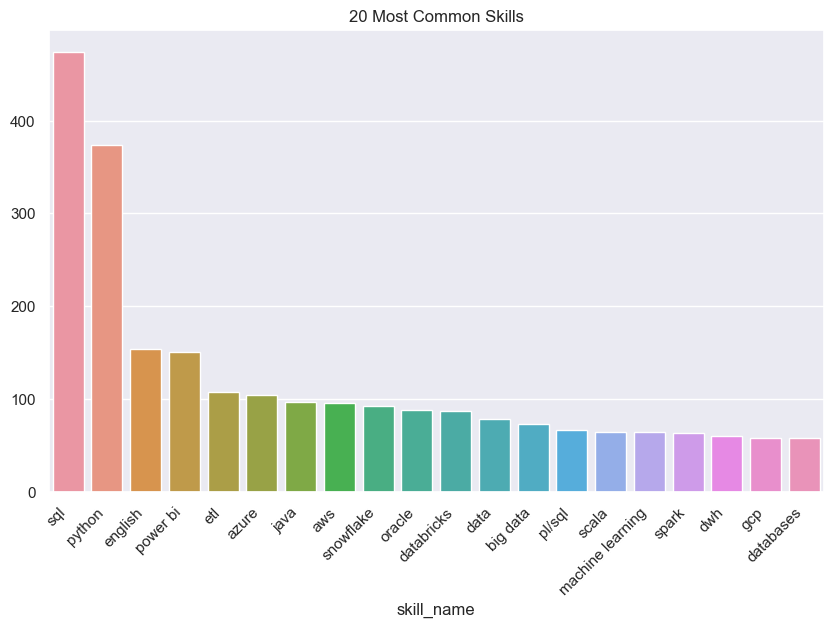

In [128]:
plt.figure(figsize=(10, 6))
sns.set(style="darkgrid")
plot = sns.barplot(x=clean_df['skill_name'].value_counts().iloc[:20].index, y=clean_df['skill_name'].value_counts().iloc[:20].values)
plot.set_title('20 Most Common Skills')
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()

In [129]:
# Sprawdzanie i zamiana wartości
common_skills_df = clean_df.copy()
mask = ~common_skills_df['skill_name'].isin(top_20_skills)
common_skills_df.loc[mask, 'skill_name'] = None


In [130]:
most_common_skills_df = common_skills_df.dropna(subset=['skill_name'])

In [131]:
most_common_skills_df.reset_index(drop=True, inplace = True)
most_common_skills_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2411 entries, 0 to 2410
Data columns (total 37 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   apply_body               0 non-null      object
 1   title                    2411 non-null   object
 2   street                   2411 non-null   object
 3   city                     2411 non-null   object
 4   country_code             2410 non-null   object
 5   address_text             2411 non-null   object
 6   marker_icon              2411 non-null   object
 7   workplace_type           2411 non-null   object
 8   company_name             2411 non-null   object
 9   company_url              2411 non-null   object
 10  company_size             2411 non-null   object
 11  experience_level         2411 non-null   object
 12  latitude                 2411 non-null   object
 13  longitude                2411 non-null   object
 14  apply_url                1509 non-null  

In [132]:
most_common_skills_df.columns

Index(['apply_body', 'title', 'street', 'city', 'country_code', 'address_text',
       'marker_icon', 'workplace_type', 'company_name', 'company_url',
       'company_size', 'experience_level', 'latitude', 'longitude',
       'apply_url', 'published_at', 'remote_interview', 'video_key',
       'video_provider', 'open_to_hire_ukrainians', 'future_consent_title',
       'future_consent', 'information_clause', 'custom_consent_title',
       'custom_consent', 'id', 'tags', 'body', 'company_logo_url',
       'banner_url', 'skills', 'remote', 'employment_types', 'multilocation',
       'company_profile', 'skill_name', 'skill_level'],
      dtype='object')

In [198]:
dummies = pd.get_dummies(most_common_skills_df['skill_name'], prefix='skill')

for col in dummies.columns:
    dummies[col] *=  most_common_skills_df['skill_level']

# Dołączanie kolumn dummies
aggregated_df = pd.concat([most_common_skills_df, dummies], axis=1)

def custom_agg(series):
    if series.name.startswith('skill'):
        return series.sum()
    else:
        return series.iat[0]


aggregated_df = aggregated_df.drop('skill_name', axis=1)
aggregated_df = aggregated_df.drop('skills', axis=1)

# Grupowanie, agregacja i reset indeksu
aggregated_df = aggregated_df.groupby('id', as_index=False).agg(custom_agg)
aggregated_df = aggregated_df.drop('skill_level', axis=1)

In [199]:
aggregated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 946 entries, 0 to 945
Data columns (total 54 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   id                       946 non-null    object
 1   apply_body               0 non-null      object
 2   title                    946 non-null    object
 3   street                   946 non-null    object
 4   city                     946 non-null    object
 5   country_code             945 non-null    object
 6   address_text             946 non-null    object
 7   marker_icon              946 non-null    object
 8   workplace_type           946 non-null    object
 9   company_name             946 non-null    object
 10  company_url              946 non-null    object
 11  company_size             946 non-null    object
 12  experience_level         946 non-null    object
 13  latitude                 946 non-null    object
 14  longitude                946 non-null    o

## Dealing with experience level - label encoding

In [200]:
aggregated_df['experience_level'].unique()

array(['mid', 'senior', 'junior'], dtype=object)

In [201]:
# label_encoder = preprocessing.LabelEncoder()
# aggregated_df['experience_level']= label_encoder.fit_transform(aggregated_df['experience_level'])
level_mapping = {'junior': 0, 'mid': 1, 'senior': 2}
aggregated_df['experience_level'] = aggregated_df['experience_level'].map(level_mapping)

In [202]:
aggregated_df['experience_level'].unique()

array([1, 2, 0])

## Dealing with 'workplace_type', 'country_code'

In [137]:
aggregated_df['workplace_type'].unique()

array(['remote', 'partly_remote', 'office'], dtype=object)

In [138]:
aggregated_df['country_code'].unique()

array(['PL', 'SK', 'CZ', 'HU', 'AT', 'SI', 'RO', 'MT', 'DE', 'UA', None,
       'EE'], dtype=object)

In [204]:
workplace_mapping= {'remote': 0, 'partly_remote': 1, 'office': 2}
country_mapping = {'PL': 0, 'SK': 1, 'CZ': 2, 'HU': 3, 'AT': 4, 'SI': 5, 'RO': 6, 'MT': 7, 'DE': 8, 'UA': 9, None: 10,
       'EE': 11}

aggregated_df['workplace_type'] =aggregated_df['workplace_type'].map(workplace_mapping)

aggregated_df['country_code'] = aggregated_df['country_code'].map(country_mapping)

## Dealing with salaries

In [140]:
df_employment_types = aggregated_df['employment_types'].apply(pd.Series)
df_employment_types.sample()

,0,1
152,"{'type': 'b2b', 'salary': None}",NaN


In [220]:
df_employment_type_1 = df_employment_types[0].apply(pd.Series, dtype='object')
df_employment_type_1= pd.concat([df_employment_type_1.drop(['salary'], axis=1),
                                 df_employment_type_1['salary'].apply(pd.Series, dtype='object')], axis=1)
df_employment_type_1['type'].unique()

array(['permanent', 'b2b', 'mandate_contract'], dtype=object)

In [142]:
df_employment_type_2 = df_employment_types[1].apply(pd.Series, dtype='object')
df_employment_type_2 = pd.concat([df_employment_type_2.drop(['salary'], axis=1),
                                  df_employment_type_2['salary'].apply(pd.Series, dtype='object')], axis=1)
df_employment_type_2.drop(columns=0, inplace = True)
df_employment_type_2.sample(10)

,type,from,to,currency
668,NaN,NaN,NaN,NaN
11,NaN,NaN,NaN,NaN
518,NaN,NaN,NaN,NaN
462,NaN,NaN,NaN,NaN
104,NaN,NaN,NaN,NaN
315,NaN,NaN,NaN,NaN
933,NaN,NaN,NaN,NaN
458,NaN,NaN,NaN,NaN
41,NaN,NaN,NaN,NaN
79,NaN,NaN,NaN,NaN


In [221]:
df_no_employment = aggregated_df.drop(columns = 'employment_types')
df_employment_1 = pd.concat([df_no_employment, df_employment_type_1], axis = 1)
df_employment_2 = pd.concat([df_no_employment, df_employment_type_2], axis = 1)
df_employment = pd.concat([df_employment_1, df_employment_2])
df_employment.dropna(subset=['type'], inplace = True)
df_employment.reset_index(drop=True, inplace = True)
df_employment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1131 entries, 0 to 1130
Data columns (total 57 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       1131 non-null   object 
 1   apply_body               0 non-null      object 
 2   title                    1131 non-null   object 
 3   street                   1131 non-null   object 
 4   city                     1131 non-null   object 
 5   country_code             1131 non-null   int64  
 6   address_text             1131 non-null   object 
 7   marker_icon              1131 non-null   object 
 8   workplace_type           1131 non-null   int64  
 9   company_name             1131 non-null   object 
 10  company_url              1131 non-null   object 
 11  company_size             1131 non-null   object 
 12  experience_level         1131 non-null   int64  
 13  latitude                 1131 non-null   object 
 14  longitude               

In [222]:
# df_employment['type']= label_encoder.fit_transform(df_employment['type'])
type_map = {'permanent': 0, 'b2b': 1, 'mandate_contract': 2}
df_employment['type'] = df_employment['type'].map(type_map)

### Convert all currencies to PLN

In [145]:
currency_list = list(df_employment[df_employment['from'].notna()]['currency'].unique())
currency_list

['pln', 'eur', 'usd']

In [146]:
selected_currency  = 'pln'
foreign_currencies = currency_list.copy()
foreign_currencies.remove(selected_currency)

In [147]:
df_with_salary = df_employment[df_employment['currency'].notna()]
df_no_salary = df_employment[df_employment['currency'].isna()]

In [148]:
df_with_salary['from'] = df_with_salary.apply(lambda row: change_currency(row['from'], row['currency'], selected_currency)
                                              if row['currency'] != selected_currency and pd.notna(row['currency'])
                                              else row['from'], axis=1)

/var/folders/mp/mpgc14lx6b9f41xmhqs4mxc80000gn/T/ipykernel_72483/2430910949.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_salary['from'] = df_with_salary.apply(lambda row: change_currency(row['from'], row['currency'], selected_currency)


In [149]:
df_with_salary['to'] = df_with_salary.apply(lambda row: change_currency(row['to'], row['currency'], selected_currency)
                                            if row['currency'] != selected_currency and pd.notna(row['currency'])
                                            else row['to'], axis=1)

/var/folders/mp/mpgc14lx6b9f41xmhqs4mxc80000gn/T/ipykernel_72483/1341338040.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_salary['to'] = df_with_salary.apply(lambda row: change_currency(row['to'], row['currency'], selected_currency)


In [150]:
df_with_salary.loc[df_with_salary['currency'] != selected_currency, 'currency'] = selected_currency

In [151]:
df_pln = pd.concat([df_with_salary, df_no_salary])
df_pln.reset_index(drop=True, inplace = True)
df_pln.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1131 entries, 0 to 1130
Data columns (total 57 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       1131 non-null   object 
 1   apply_body               0 non-null      object 
 2   title                    1131 non-null   object 
 3   street                   1131 non-null   object 
 4   city                     1131 non-null   object 
 5   country_code             1131 non-null   int64  
 6   address_text             1131 non-null   object 
 7   marker_icon              1131 non-null   object 
 8   workplace_type           1131 non-null   int64  
 9   company_name             1131 non-null   object 
 10  company_url              1131 non-null   object 
 11  company_size             1131 non-null   object 
 12  experience_level         1131 non-null   int64  
 13  latitude                 1131 non-null   object 
 14  longitude               

at this stage df includes:
- offers with marker icon 'data'
- ordered employment column
- cleaned company_size column
- selected offers with the 30 most popular skills among 'data', both with given and unknown salary
- experience_level, country_code, employment_type, workplace_type and skills encoded columns
- offers in a foreign currency converted into PLN

In [152]:
#cleaning up and encoding company sizes

#cleaning up sizes that contain '-'
company_size_df = df_pln[df_pln['company_size'].str.contains('-')][['company_size']]
company_size_df

,company_size
5,11-50
31,51-200
32,51-200
33,51-200
34,51-200
...,...
996,101-500
1017,200-220
1018,1001-5000
1095,-


In [153]:
company_size_df['company_size_1'] = company_size_df['company_size'].str.split('-').str[0]
company_size_df['company_size_2']  = company_size_df['company_size'].str.split('-').str[-1]

In [154]:
company_size_df[company_size_df['company_size']=='-']

,company_size,company_size_1,company_size_2
902,-,,
903,-,,
1095,-,,


In [155]:
company_size_df = company_size_df[company_size_df['company_size'] != '-']
company_size_df[company_size_df['company_size']=='-']

,company_size,company_size_1,company_size_2


In [156]:
# company_size_df = company_size_df.copy()
company_size_df['company_size_1'] = pd.to_numeric(company_size_df['company_size_1'])
company_size_df['company_size_2'] = pd.to_numeric(company_size_df['company_size_2'])
company_size_df['avg_company_size'] = (company_size_df['company_size_1'] + company_size_df['company_size_2']) / 2

company_size_df = company_size_df[['avg_company_size']]
company_size_df

/var/folders/mp/mpgc14lx6b9f41xmhqs4mxc80000gn/T/ipykernel_72483/2302636781.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_size_df['company_size_1'] = pd.to_numeric(company_size_df['company_size_1'])
/var/folders/mp/mpgc14lx6b9f41xmhqs4mxc80000gn/T/ipykernel_72483/2302636781.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_size_df['company_size_2'] = pd.to_numeric(company_size_df['company_size_2'])
/var/folders/mp/mpgc14lx6b9f41xmhqs4mxc80000gn/T/ipykernel_72483/2302636781.py:4: Sett

,avg_company_size
5,30.5
31,125.5
32,125.5
33,125.5
34,125.5
...,...
917,300.5
996,300.5
1017,210.0
1018,3000.5


In [157]:
df_avg_company_size = pd.merge(df_pln, company_size_df, left_index=True, right_index=True, how = 'outer')

In [158]:
df_avg_company_size['company_size'] = df_avg_company_size['company_size'].apply(remove_mark)
df_avg_company_size['company_size'].unique()

array(['250', '6000', '1150', '200', '30', '51200', '1001  5000', '100',
       '500', '6080', '60000', '150', '110', '1000', '2030', '50',
       '300000', '125', '1025', '16', '120', '1020', '3040', '450', '40',
       '1400', '1530', '7000', '5011000', '750', '350', '80', '87',
       '101500', '50100', '60', '1520', '200250', '50  100', '2000',
       '900', '460', '430', '300', '60  70', '2650', '22 200', '30000',
       '1525', ' 30', '1500', '280', '2 000', '100200', '51100', '170',
       '5000', '8600', '500 000', '70100', '9000', '501', '1700', '600',
       '67007000', '400', '700', '100 000', '', '55000', '10000', '1600',
       '800', '3000', '22000', '200220', '10015000', '40000', '10 000 ',
       '3500', '70', '650'], dtype=object)

In [159]:
df_avg_company_size['company_size'] = df_avg_company_size['company_size'].apply(remove_mark)
df_avg_company_size['company_size'].unique()

array(['250', '6000', '1150', '200', '30', '51200', '10015000', '100',
       '500', '6080', '60000', '150', '110', '1000', '2030', '50',
       '300000', '125', '1025', '16', '120', '1020', '3040', '450', '40',
       '1400', '1530', '7000', '5011000', '750', '350', '80', '87',
       '101500', '50100', '60', '1520', '200250', '2000', '900', '460',
       '430', '300', '6070', '2650', '22200', '30000', '1525', '1500',
       '280', '100200', '51100', '170', '5000', '8600', '500000', '70100',
       '9000', '501', '1700', '600', '67007000', '400', '700', '100000',
       '', '55000', '10000', '1600', '800', '3000', '22000', '200220',
       '40000', '3500', '70', '650'], dtype=object)

In [160]:
df_avg_company_size['company_size'] = pd.to_numeric(df_avg_company_size['company_size'])

In [161]:
df_avg_company_size['avg_company_size'] = df_avg_company_size.apply(
    lambda row: row['company_size'] if pd.isna(row['avg_company_size']) else row['avg_company_size'],
    axis=1
).astype('float')

In [162]:
df_avg_company_size.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1131 entries, 0 to 1130
Data columns (total 58 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       1131 non-null   object 
 1   apply_body               0 non-null      object 
 2   title                    1131 non-null   object 
 3   street                   1131 non-null   object 
 4   city                     1131 non-null   object 
 5   country_code             1131 non-null   int64  
 6   address_text             1131 non-null   object 
 7   marker_icon              1131 non-null   object 
 8   workplace_type           1131 non-null   int64  
 9   company_name             1131 non-null   object 
 10  company_url              1131 non-null   object 
 11  company_size             1128 non-null   float64
 12  experience_level         1131 non-null   int64  
 13  latitude                 1131 non-null   object 
 14  longitude                1131

In [163]:
to_csv_date(df_avg_company_size,'offers_API_ready_to_analyze')

# BUILDING REGRESSION MODEL

In [164]:
df_reg = df_avg_company_size.copy()
#pd.read_csv('https://raw.githubusercontent.com/KKozakiewicz/predict_salaries/main/ready_to_analyze_08252023_.csv')

In [165]:
df_reg.sample(5)

,id,apply_body,title,street,city,country_code,address_text,marker_icon,workplace_type,company_name,...,skill_python,skill_scala,skill_snowflake,skill_spark,skill_sql,type,from,to,currency,avg_company_size
128,cloudfide-power-bi-developer-lublin,None,power bi developer,Centrum,Lublin,6,"Centrum, Lublin",data,2,CLOUDFIDE,...,0,0,0,0,4,0,11000.0,22000.0,pln,50.0
626,xtb-head-of-ai-d68fb7a8-1a35-4b02-99ec-05ede28...,None,head of ai,Centrum,Kielce,6,"Centrum, Kielce",data,2,XTB,...,5,0,0,0,0,0,30000.0,40000.0,pln,500.0
324,idego-data-engineer-236a5d44-40fb-407f-8e42-31...,None,data engineer,-,Warszawa,6,"-, Warszawa",data,2,Idego,...,3,0,4,0,3,0,20000.0,30000.0,pln,120.0
542,square-one-data-engineer-bialystok,None,data engineer,Centrum,Białystok,6,"Centrum, Białystok",data,2,Square One,...,4,0,0,0,0,0,26000.0,31920.0,pln,450.0
758,tpay-bi-developer-tableau,None,bi developer (tableau),"plac Andersa 3, 17 piętro",Poznań,6,"plac Andersa 3, 17 piętro, Poznań",data,2,Tpay,...,3,0,0,0,0,2,14000.0,18000.0,pln,100.0


In [166]:
# remove columns that won't be taken into consideration
df_reg_limit=df_reg.drop(columns = ['id', 'apply_body', 'title', 'company_size', 'street', 'city', 'address_text', 'marker_icon', 'company_name', 'company_url', 'latitude', 'longitude', 'apply_url', 'published_at', 'remote_interview', 'video_key', 'video_provider', 'open_to_hire_ukrainians', 'future_consent_title', 'future_consent', 'information_clause', 'custom_consent_title', 'custom_consent', 'tags', 'body', 'company_logo_url', 'banner_url', 'multilocation', 'company_profile', 'currency'])


In [167]:
df_reg_limit.head()

,country_code,workplace_type,experience_level,remote,skill_aws,skill_azure,skill_big data,skill_data,skill_databases,skill_databricks,...,skill_power bi,skill_python,skill_scala,skill_snowflake,skill_spark,skill_sql,type,from,to,avg_company_size
0,6,2,2,True,3,0,0,0,0,0,...,0,4,0,3,1,4,0,31000.0,38000.0,250.0
1,6,2,2,True,3,0,0,0,0,0,...,0,4,0,3,1,4,0,25000.0,30000.0,250.0
2,6,2,1,True,0,0,0,0,0,3,...,0,4,0,0,0,4,2,13000.0,25000.0,6000.0
3,6,2,1,True,0,0,0,0,0,3,...,0,4,0,0,0,4,2,13000.0,25000.0,6000.0
4,6,2,1,True,0,0,0,0,0,3,...,0,4,0,0,0,4,2,13000.0,25000.0,6000.0


In [168]:
df_reg_limit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1131 entries, 0 to 1130
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   country_code            1131 non-null   int64  
 1   workplace_type          1131 non-null   int64  
 2   experience_level        1131 non-null   int64  
 3   remote                  1131 non-null   bool   
 4   skill_aws               1131 non-null   int64  
 5   skill_azure             1131 non-null   int64  
 6   skill_big data          1131 non-null   int64  
 7   skill_data              1131 non-null   int64  
 8   skill_databases         1131 non-null   int64  
 9   skill_databricks        1131 non-null   int64  
 10  skill_dwh               1131 non-null   int64  
 11  skill_english           1131 non-null   int64  
 12  skill_etl               1131 non-null   int64  
 13  skill_gcp               1131 non-null   int64  
 14  skill_java              1131 non-null   int64

In [169]:
# extract rows with no salary information
df_no_salaries = df_reg_limit[df_reg_limit['to'].isna()].reset_index(drop=True)
df_no_salaries.info()

# extract rows with salary information
df_salaries = df_reg_limit[df_reg_limit['to'].notna()].reset_index(drop=True)
df_salaries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   country_code            342 non-null    int64  
 1   workplace_type          342 non-null    int64  
 2   experience_level        342 non-null    int64  
 3   remote                  342 non-null    bool   
 4   skill_aws               342 non-null    int64  
 5   skill_azure             342 non-null    int64  
 6   skill_big data          342 non-null    int64  
 7   skill_data              342 non-null    int64  
 8   skill_databases         342 non-null    int64  
 9   skill_databricks        342 non-null    int64  
 10  skill_dwh               342 non-null    int64  
 11  skill_english           342 non-null    int64  
 12  skill_etl               342 non-null    int64  
 13  skill_gcp               342 non-null    int64  
 14  skill_java              342 non-null    in

In [170]:
df_salaries_sorted = df_salaries.sort_values(by='from', ascending=True)
df_salaries_sorted.head()

,country_code,workplace_type,experience_level,remote,skill_aws,skill_azure,skill_big data,skill_data,skill_databases,skill_databricks,...,skill_power bi,skill_python,skill_scala,skill_snowflake,skill_spark,skill_sql,type,from,to,avg_company_size
189,6,2,1,True,3,0,0,0,0,0,...,0,3,0,0,0,5,0,1800.0,2300.0,16.0
701,6,0,0,False,0,0,0,0,0,0,...,0,0,0,0,0,1,2,3600.0,5090.0,75.0
441,6,1,0,False,0,0,0,0,0,0,...,0,1,0,0,0,3,2,4000.0,8000.0,460.0
420,6,1,0,False,0,0,0,0,0,0,...,0,0,0,0,0,3,2,4000.0,7000.0,25.0
410,6,0,0,False,0,0,0,0,0,0,...,0,0,0,0,0,1,0,4337.0,6133.0,75.0


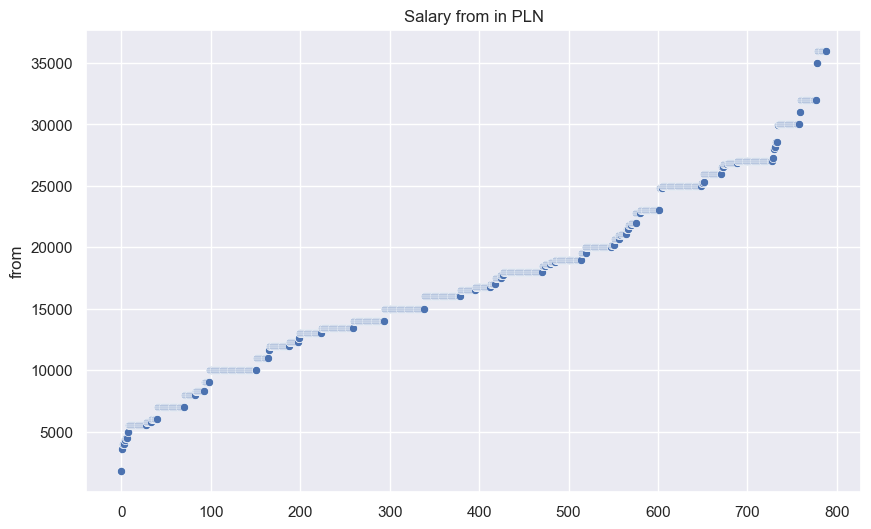

In [171]:
plt.figure(figsize=(10, 6))
sns.set(style="darkgrid")
plot = sns.scatterplot(x=np.arange(len(df_salaries_sorted)), y=df_salaries_sorted['from'])
plot.set_title('Salary from in PLN')

plt.show()

In [172]:
# split the dataset into training and test sets, now only salary_from is investigated
X = df_salaries.drop(columns=['from','to'])
y = df_salaries['from']

In [173]:
# normalizing the data
scl = StandardScaler()
X_scaled = pd.DataFrame(scl.fit_transform(X), columns = X.columns)

In [310]:
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Random Forest

In [311]:
# Initialize the RandomForestRegressor model
rf_regressor = RandomForestRegressor()

# Define the parameter grid for the grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a GridSearchCV object
gs = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')

# Fit the GridSearchCV object to the training data
gs.fit(X_train, y_train)

# Get the best model with tuned hyperparameters
best_model = gs.best_estimator_

# Print best parameters
print("Best Parameters:", gs.best_params_)

# Predict on the test set
y_pred = best_model.predict(X_test)

# Evaluate the best model
evaluate_regression_model(best_model, X_test, y_test)

Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Regression Model Evaluation:
Mean Absolute Error (MAE): 893.59
Mean Squared Error (MSE): 6837577.64
Root Mean Squared Error (RMSE): 2614.88
R-squared (R2): 0.86


In [314]:
RF_model = RandomForestRegressor(max_depth = 20, min_samples_leaf= 1, min_samples_split=2, n_estimators=100)
RF_model.fit(X_train, y_train)

evaluate_regression_model(RF_model, X_test, y_test)

Regression Model Evaluation:
Mean Absolute Error (MAE): 852.33
Mean Squared Error (MSE): 6426856.75
Root Mean Squared Error (RMSE): 2535.12
R-squared (R2): 0.87


##MAE distribution

<Axes: ylabel='Count'>

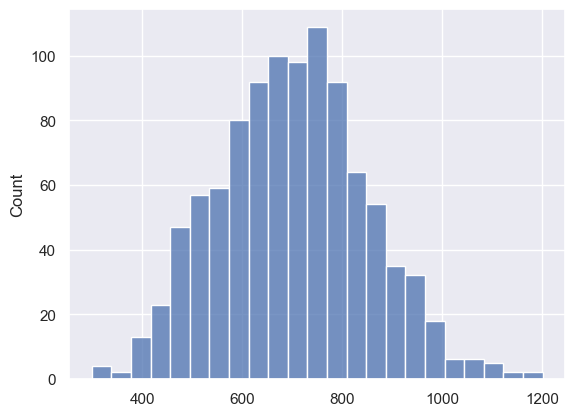

In [177]:
mae = []

for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    RF_model = RandomForestRegressor(max_depth=20, min_samples_split = 2, n_estimators = 150)

    RF_model.fit(X_train, y_train)

    mae.append(mean_absolute_error(y_test, RF_model.predict(X_test)))

sns.set_style("darkgrid")
sns.histplot(mae)

In [179]:
import sklearn
scikit_version = sklearn.__version__
print(scikit_version)

1.2.2


In [180]:
joblib.dump(RF_model, f"RF_model_{scikit_version}.pkl")

['RF_model_1.2.2.pkl']

# Reading job offer and preparing the data

In [379]:
job_offer = 'https://justjoin.it/offers/link-group-senior-data-scientist-graph-analytics'
job_offer_api = job_offer.replace("https://justjoin.it/offers/", "https://justjoin.it/api/offers/")

In [380]:
response = requests.get(job_offer_api)
job_data = response.json()

In [381]:
with open('output.txt', 'r') as file:
    lines = file.readlines()
    top_20_skills = [line.strip() for line in lines]

print(top_20_skills)

['sql', 'python', 'english', 'power bi', 'etl', 'azure', 'java', 'aws', 'snowflake', 'oracle', 'databricks', 'data', 'big data', 'pl/sql', 'scala', 'machine learning', 'spark', 'dwh', 'gcp', 'databases']


In [382]:
offer_data = []

for skill in job_data['skills']:
    # print(skill['name'])
    new_row = job_data.copy()
    new_row['skill_name'] = skill['name']
    new_row['skill_level'] = skill['level']
    offer_data.append(new_row)


offer_df = pd.DataFrame(offer_data)
offer_df = standardize_text(offer_df, "title")
offer_df = standardize_text(offer_df, "skill_name")

offer_dummies = pd.DataFrame()

for col_name in sorted(top_20_skills):
    offer_dummies["skill_" + col_name] = 0

offer_dummies.loc[0] = 0

In [383]:
final = []
for skill in offer_df['skill_name']:
    new_dummy = offer_dummies.copy()
    if skill in top_20_skills:
        new_dummy[f"skill_{skill}"] = 1
    final.append(new_dummy)

all_dummies = pd.concat(final, ignore_index=True)

In [384]:



for col in all_dummies.columns:
    all_dummies[col] *=  offer_df['skill_level']

# Dołączanie kolumn dummies
aggregated_offer_df = pd.concat([offer_df, all_dummies], axis=1)

def custom_agg(series):
    if series.name.startswith('skill'):
        return series.sum()
    else:
        return series.iat[0]


aggregated_offer_df = aggregated_offer_df.drop('skill_name', axis=1)
aggregated_offer_df = aggregated_offer_df.drop('skills', axis=1)

# Grupowanie, agregacja i reset indeksu
aggregated_offer_df = aggregated_offer_df.groupby('id', as_index=False).agg(custom_agg)
aggregated_offer_df = aggregated_offer_df.drop('skill_level', axis=1)

level_mapping = {'junior': 0, 'mid': 1, 'senior': 2}
workplace_mapping= {'remote': 0, 'partly_remote': 1, 'office': 2}
country_mapping = {'PL': 0, 'SK': 1, 'CZ': 2, 'HU': 3, 'AT': 4, 'SI': 5, 'RO': 6, 'MT': 7, 'DE': 8, 'UA': 9, 'None': 10,
       'EE': 11}

aggregated_offer_df['experience_level'] = aggregated_offer_df['experience_level'].map(level_mapping)

aggregated_offer_df['workplace_type'] =aggregated_offer_df['workplace_type'].map(workplace_mapping)

aggregated_offer_df['country_code'] = aggregated_offer_df['country_code'].map(country_mapping)

offer_employment_types = aggregated_offer_df['employment_types'].apply(pd.Series)
offer_employment_type = offer_employment_types[0].apply(pd.Series)
offer_employment_type= pd.concat([offer_employment_type.drop(['salary'], axis=1),
                                 offer_employment_type['salary'].apply(pd.Series)], axis=1)

offer_no_employment = aggregated_offer_df.drop(columns = 'employment_types')
offer_employment = pd.concat([offer_no_employment, offer_employment_type], axis = 1)

type_map = {'permanent': 0, 'b2b': 1, 'mandate_contract': 2}
offer_employment['type'] = offer_employment['type'].map(type_map)

In [385]:
offer_employment['company_size'][0]

'200-250'

In [386]:
def standardize_company_size(company_size_value):
    company_size_value = str(company_size_value)
    if (company_size_value == '-' or company_size_value == '' or company_size_value == ' ' or company_size_value == 'None'):
        size = 0.0
    elif '-' in company_size_value:
        min_value, max_value = company_size_value.split('-')
        size = 0.5 * (float(min_value) + float(max_value))
    elif '+' in company_size_value:
        size = float(company_size_value.replace('+', ''))
    elif ' ' in company_size_value:
        size = float(company_size_value.replace(' ', ''))
    else:
        size = float(company_size_value)

    return size

In [390]:
offer_employment['avg_company_size'] = offer_employment['company_size'].apply(lambda x: standardize_company_size(x))

offer=offer_employment.drop(columns = ['id', 'from', 'to', 'currency','company_size', 'company_profile','apply_body', 'title', 'street', 'city', 'address_text', 'marker_icon', 'company_name', 'company_url', 'latitude', 'longitude', 'apply_url', 'published_at', 'remote_interview', 'video_key', 'video_provider', 'open_to_hire_ukrainians', 'future_consent_title', 'future_consent', 'information_clause', 'custom_consent_title', 'custom_consent', 'tags', 'body', 'company_logo_url', 'banner_url', 'multilocation'], errors='ignore')
# scl = StandardScaler()
# offer_scaled = pd.DataFrame(scl.fit_transform(offer), columns = offer.columns)

In [391]:
offer

,country_code,workplace_type,experience_level,remote,skill_aws,skill_azure,skill_big data,skill_data,skill_databases,skill_databricks,...,skill_oracle,skill_pl/sql,skill_power bi,skill_python,skill_scala,skill_snowflake,skill_spark,skill_sql,type,avg_company_size
0,0,1,2,False,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,225.0


In [392]:
# Predict on the test set
# pred = RF_model.predict(offer_scaled)
pred = RF_model.predict(offer)

In [393]:
print(pred)

[25581.9]


In [ ]:
'''
company size, from, to i inne, tylko, jeeli faktycznie istnieją w dataframe
NaN w country code jeśli nan to 0
'''